In [1]:
# Montamos el Drive al Notebook
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
import cv2

#Análisis de serie de tiempo para presa 'La Purisima Guanajuato'

In [22]:
#Lectura del archivo en donde se tienen las 'medidas' de la presa y fechas de cada imágen
purisima = pd.read_csv(f'/content/drive/MyDrive/HackathonAiLab2021/Code/images3/cantidad_de_agua_PresaLaPurisimaGto.csv')
purisima = purisima.iloc[:,[2,3,4,6]]
purisima.columns = ['anio', 'mes','dia','area']
purisima['Date'] = purisima.anio.astype(str)+purisima.mes.astype(str).str.zfill(2)+purisima.dia.astype(str).str.zfill(2)
purisima['Date'] = pd.to_datetime(purisima['Date'],format='%Y/%m/%d')
purisima = purisima.sort_values('Date')
purisima = purisima.groupby('Date').agg({'area':np.mean}).iloc[1:,:].reset_index()
purisima

,Date,area
0,2019-01-05,550880.0
1,2019-01-10,546981.0
2,2019-01-20,540835.0
3,2019-01-25,539725.0
4,2019-02-04,538115.5
...,...,...
127,2021-08-17,423625.0
128,2021-09-21,586767.5
129,2021-10-11,621293.5
130,2021-11-05,633656.0


In [42]:
#Dado que no se tienen intervalos de fechas iguales entre la información, se tomará un arreglo con freq de 5 días (patrón que se ve en los datos)
#y sobre él será la información que se tome
fechas = pd.date_range(start= purisima.Date.iloc[0] , end = purisima.Date.iloc[-1], freq='5D')
fechas = pd.DataFrame(fechas, columns=['Date'])

In [30]:
purisima_data = fechas.merge(purisima,on ='Date', how = 'left')
purisima_data.Date= pd.to_datetime(purisima_data.Date, dayfirst=True)
purisima_data.set_index('Date', inplace=True)
purisima_data.index.freq = '5D'
purisima_data.tail(11)

,area
Date,
2021-09-21,586767.5
2021-09-26,NaN
2021-10-01,NaN
2021-10-06,NaN
2021-10-11,621293.5
2021-10-16,NaN
2021-10-21,NaN
2021-10-26,NaN
2021-10-31,NaN


### Manejo de valores faltantes

In [37]:
purisima_data.isna().sum()/len(purisima_data) #36% de valores faltantes
purisima_data.area = purisima_data.area.fillna(value=purisima_data.area.median())

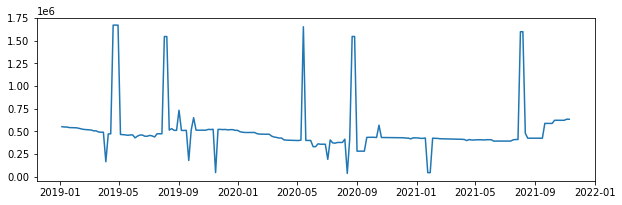

In [41]:
fig = plt.figure(figsize = (10,3))
plt.plot(purisima_data['area'])
plt.show()

###Estacionariedad

In [43]:
sts.adfuller(purisima_data.area)

(-9.042318101404007,
 5.0942737649927535e-15,
 1,
 207,
 {'1%': -3.4623415245233145,
  '10%': -2.574267439846904,
  '5%': -2.875606128263243},
 5332.806373825336)

Se rechaza $H_0$ donde,

$H_0$: la serie no es estacionaria

###Homocedasticidad

In [44]:
purisima_data.area.describe()

count    2.090000e+02
mean     4.992210e+05
std      2.659019e+05
min      3.564250e+04
25%      4.070620e+05
50%      4.337430e+05
75%      5.121090e+05
max      1.670557e+06
Name: area, dtype: float64

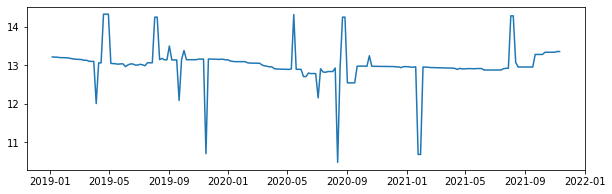

In [47]:
#No es una serie homocedastica,- entonces se aplica la transformación log para bajar varianza
purisima_h = np.log(purisima_data.area)
fig = plt.figure(figsize = (10,3))
plt.plot(purisima_h)
plt.show()


In [48]:
sts.adfuller(purisima_h) #se conserva la estacionariedad

(-9.155118121872638,
 2.6224635017035516e-15,
 1,
 207,
 {'1%': -3.4623415245233145,
  '10%': -2.574267439846904,
  '5%': -2.875606128263243},
 245.65999540721475)

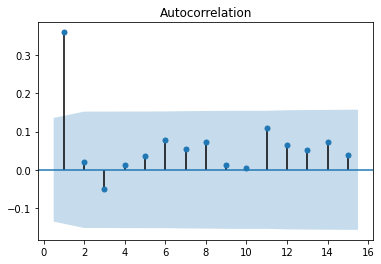

In [50]:
sgt.plot_acf(purisima_h, lags = 15, zero = False)
plt.show()

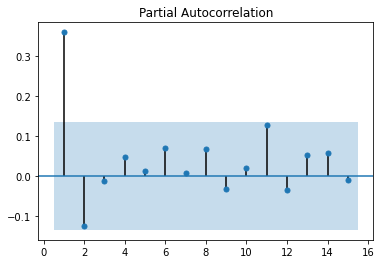

In [51]:
sgt.plot_pacf(purisima_h, lags = 15, zero = False, method=('ols'))
plt.show()

### Training y testing

In [52]:
size = int(len(purisima_h)*0.9)
data_train = purisima_h.iloc[:size]
data_test = purisima_h.iloc[size:]
data_train.tail()

Date
2021-07-08    12.878992
2021-07-13    12.878992
2021-07-18    12.912718
2021-07-23    12.922286
2021-07-28    12.922286
Freq: 5D, Name: area, dtype: float64

In [54]:
data_test.head()

Date
2021-08-02    14.284330
2021-08-07    14.284330
2021-08-12    13.077487
2021-08-17    12.956604
2021-08-22    12.956604
Freq: 5D, Name: area, dtype: float64

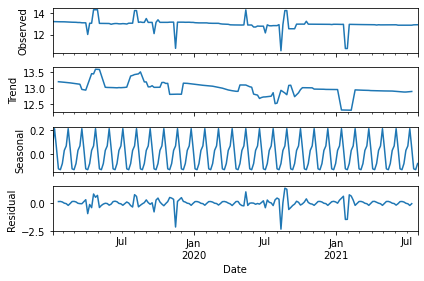

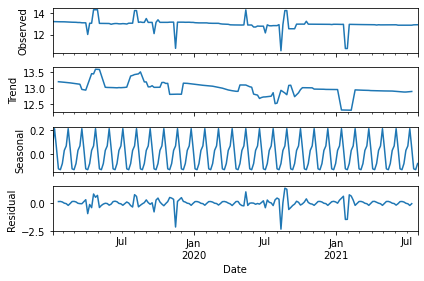

In [57]:
#descomposicion de la serie
s_dec = seasonal_decompose(data_train, 'additive')
s_dec.plot()
#Se visualiza una ligera tendencia hacia abajo a lo largo del tiempo
#No se reconoce componente estacional

### Implementación de modelos

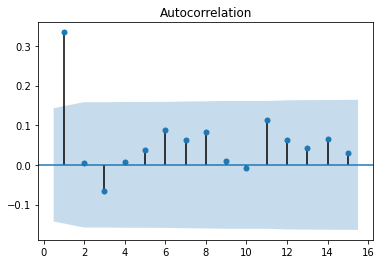

In [59]:
sgt.plot_acf(data_train, lags = 15, zero = False)
plt.show()

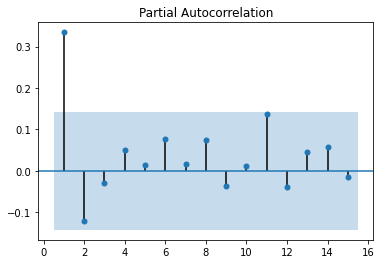

In [60]:
sgt.plot_pacf(data_train, lags = 15, zero = False, method=('ols'))
plt.show()

Dada la información anterior, el candidato por ACF Y PACF sería ARIMA(1,0,1), sin embargo se intentaron probar los siguientes modelos de series de tiempo


*   ARIMA(1,0,1) $\rightarrow$ AIC: 233.4359
*   ARIMA(1,0,0) $\rightarrow$ AIC: 233.5001
*   ARIMA(0,0,1) $\rightarrow$ AIC: 231.8937
*   ARIMA(2,0,2) $\rightarrow$ AIC: 236.3374
*   ARIMA(0,0,2) $\rightarrow$ AIC: 233.2248
*   ARIMA(2,0,0) $\rightarrow$ AIC: 232.7572

Cabe mencionar que incluso se tomó una diferencia estacionaria para probar otros modelos y estos *no* fueron mejor que los anteriores



Hechas las pruebas necesarias, se optó por desarrollar el modelo ARIMA(1,0,1), sin embargo los coeficientes no son significativamente distintos de cero, por lo que tampoco se puede concluir que con este modelo se pueda modelar adecuadamente el comportamiento de la serie

In [61]:
from statsmodels.tsa.arima_model import ARIMA
#ARIMA(1,0,1)
modelo_101 = ARIMA(data_train, order =(1,0,1))
results_101 = modelo_101.fit()
print(results_101.summary())

                              ARMA Model Results                              
Dep. Variable:                   area   No. Observations:                  188
Model:                     ARMA(1, 1)   Log Likelihood                -112.718
Method:                       css-mle   S.D. of innovations              0.441
Date:                Sun, 14 Nov 2021   AIC                            233.436
Time:                        12:16:16   BIC                            246.382
Sample:                    01-05-2019   HQIC                           238.681
                         - 07-28-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.9919      0.045    285.850      0.000      12.903      13.081
ar.L1.area     0.1175      0.171      0.689      0.492      -0.217       0.452
ma.L1.area     0.2506      0.161      1.553      0.1

AJUSTE CON MODELO ARIMA(1,0,1)


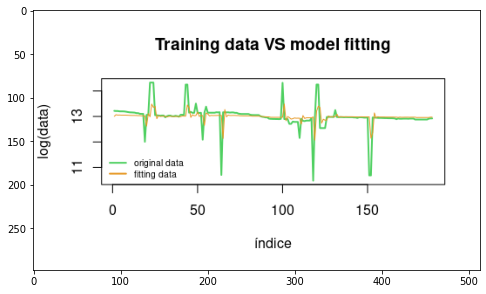

In [124]:
img = cv2.imread('/content/drive/MyDrive/HackathonAiLab2021/Code/images3/purisima.png')
fig = plt.figure(figsize = (8,10))
plt.imshow(img)
print('AJUSTE CON MODELO ARIMA(1,0,1)')
plt.show()

Lo anterior es resultado de que no se tienen las medidas para rangos contantes de fechas, por lo que se tuvieron que imputar otros valores en las fechas donde no se contaba con registro. Si se trabajaba con la serie original el problema iba a verse al momento de la predicción ya que no se contaría con un rango de tiempo igual entre cada imagen y por tanto no se sabría con certeza que fechas se están prediciendo.

#Análisis de serie de tiempo para 'El Lago de Chapala'

In [95]:
#Lectura del archivo en donde se tienen las 'medidas' del lago y fechas de cada imágen
chapala = pd.read_csv(f'/content/drive/MyDrive/HackathonAiLab2021/Code/images3/cantidad_de_agua_LagoDeChapala.csv')
chapala = chapala.iloc[:,[2,3,4,6]]
chapala.columns = ['anio', 'mes','dia','area']
chapala['Date'] = chapala.anio.astype(str)+chapala.mes.astype(str).str.zfill(2)+chapala.dia.astype(str).str.zfill(2)
chapala['Date'] = pd.to_datetime(chapala['Date'],format='%Y/%m/%d')
chapala = chapala.sort_values('Date')
chapala = chapala.groupby('Date').agg({'area':np.mean}).iloc[2:,:].reset_index()
chapala

,Date,area
0,2019-01-08,434751.5
1,2019-01-13,1630839.5
2,2019-01-18,321418.5
3,2019-01-23,434824.5
4,2019-02-02,432934.5
...,...,...
138,2021-09-09,633587.0
139,2021-09-24,1555295.0
140,2021-10-09,1615652.5
141,2021-10-14,1654066.5


In [97]:
#Dado que no se tienen intervalos de fechas iguales entre la información, se tomará un arreglo con freq de 5 días (patrón que se ve en los datos)
#y sobre él será la información que se tome
fechas = pd.date_range(start= chapala.Date.iloc[0] , end = chapala.Date.iloc[-1], freq='5D')
fechas = pd.DataFrame(fechas, columns=['Date'])

In [105]:
chapala_data = fechas.merge(chapala,on ='Date', how = 'left')
chapala_data.Date= pd.to_datetime(chapala_data.Date, dayfirst=True)
chapala_data.set_index('Date', inplace=True)
chapala_data.index.freq = '5D'
chapala_data.tail(11)

,area
Date,
2021-08-30,NaN
2021-09-04,NaN
2021-09-09,633587.0
2021-09-14,NaN
2021-09-19,NaN
2021-09-24,1555295.0
2021-09-29,NaN
2021-10-04,NaN
2021-10-09,1615652.5


### Manejo de valores faltantes

In [112]:
chapala_data.isna().sum()/len(chapala_data) #30% de valores faltantes
chapala_data.area = chapala_data.area.fillna(value=chapala_data.area.median())

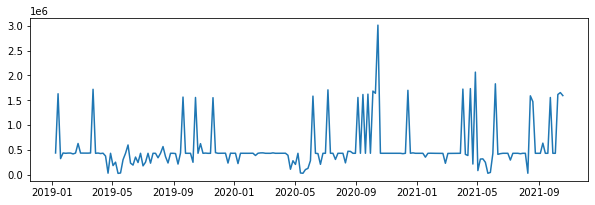

In [113]:
fig = plt.figure(figsize = (10,3))
plt.plot(chapala_data['area'])
plt.show()

###Estacionariedad

In [114]:
sts.adfuller(chapala_data.area)

(-7.311119240062083,
 1.263601533289284e-10,
 1,
 202,
 {'1%': -3.4631437906252636,
  '10%': -2.574454682874228,
  '5%': -2.8759570379821047},
 5426.319973027507)

Se rechaza $H_0$ donde,

$H_0$: la serie no es estacionaria

###Homocedasticidad

In [115]:
chapala_data.area.describe()

count    2.040000e+02
mean     5.352364e+05
std      4.544817e+05
min      2.288050e+04
25%      4.206085e+05
50%      4.286030e+05
75%      4.304648e+05
max      3.016144e+06
Name: area, dtype: float64

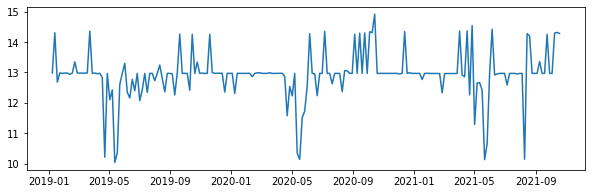

In [116]:
#No es una serie homocedastica,- entonces se aplica la transformación log para bajar varianza
chapala_h = np.log(chapala_data.area)
fig = plt.figure(figsize = (10,3))
plt.plot(chapala_h)
plt.show()


In [118]:
sts.adfuller(chapala_h) #se conserva la estacionariedad

(-4.6537908700853965,
 0.00010268315189004554,
 3,
 200,
 {'1%': -3.463476079125, '10%': -2.574532225, '5%': -2.876102355},
 430.9369388987709)

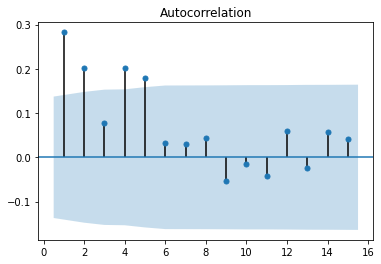

In [119]:
sgt.plot_acf(chapala_h, lags = 15, zero = False)
plt.show()

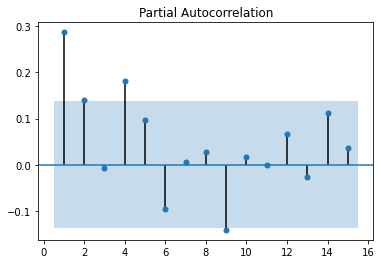

In [120]:
sgt.plot_pacf(chapala_h, lags = 15, zero = False, method=('ols'))
plt.show()

### Training y testing

In [121]:
size = int(len(chapala_h)*0.9)
data_train = chapala_h.iloc[:size]
data_test = chapala_h.iloc[size:]
data_train.tail()

Date
2021-06-16    12.950838
2021-06-21    12.968286
2021-06-26    12.968286
2021-07-01    12.968286
2021-07-06    12.584620
Freq: 5D, Name: area, dtype: float64

In [122]:
data_test.head()

Date
2021-07-11    12.968286
2021-07-16    12.968286
2021-07-21    12.968286
2021-07-26    12.947348
2021-07-31    12.968286
Freq: 5D, Name: area, dtype: float64

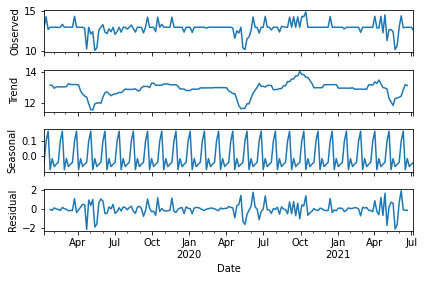

In [134]:
#descomposicion de la serie
s_dec = seasonal_decompose(data_train, 'additive')
s_dec.plot()
plt.show()
#No se visualiza tendencia

### Implementación de modelos

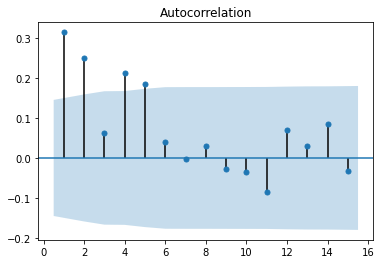

In [125]:
sgt.plot_acf(data_train, lags = 15, zero = False)
plt.show()

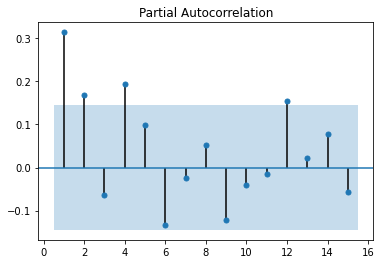

In [126]:
sgt.plot_pacf(data_train, lags = 15, zero = False, method=('ols'))
plt.show()

Dada la información anterior se intentaron probar los siguientes modelos de series de tiempo


*   ARIMA(4,0,0) $\rightarrow$ AIC: 396.677
*   ARIMA(2,0,0) $\rightarrow$ AIC: 400.4813
*   ARIMA(1,0,0) $\rightarrow$ AIC: 403.7125
*   ARIMA(1,0,1) $\rightarrow$ AIC: 400.8049
*   ARIMA(2,0,1) $\rightarrow$ AIC: 400.324

Cabe mencionar que incluso se tomó una diferencia estacionaria para probar otros modelos y estos *no* fueron mejor que los anteriores



Hechas las pruebas necesarias, se optó por desarrollar el modelo ARIMA(2,0,0) a pesar de tener un AIC mayor que el AIC dado para el ARIMA(4,0,0) ya que en este último los coeficientes no son significativamente distintos de cero.

In [128]:
from statsmodels.tsa.arima_model import ARIMA
#ARIMA(4,0,0)
modelo_400 = ARIMA(data_train, order =(2,0,0))
results_400 = modelo_400.fit()
print(results_400.summary())

                              ARMA Model Results                              
Dep. Variable:                   area   No. Observations:                  183
Model:                     ARMA(2, 0)   Log Likelihood                -196.241
Method:                       css-mle   S.D. of innovations              0.707
Date:                Sun, 14 Nov 2021   AIC                            400.481
Time:                        13:41:02   BIC                            413.319
Sample:                    01-08-2019   HQIC                           405.685
                         - 07-06-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.8894      0.091    141.908      0.000      12.711      13.067
ar.L1.area     0.2592      0.073      3.567      0.000       0.117       0.402
ar.L2.area     0.1688      0.073      2.305      0.0

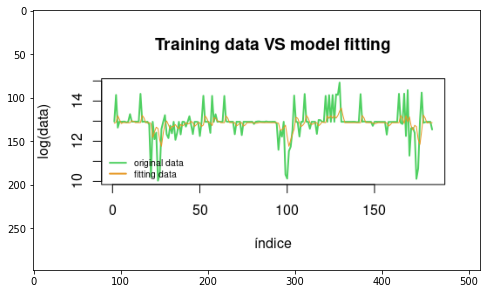

In [130]:
img = cv2.imread('/content/drive/MyDrive/HackathonAiLab2021/Code/images3/chapala.png')
fig = plt.figure(figsize = (8,10))
plt.imshow(img)
plt.show()

Como se puede visualizar en la imagen anteriorcon este modelo no se puede capturar un buen % de varianza de los datos originales.

###Análisis de residuales

In [131]:
residuales = results_400.resid[1:]
sts.adfuller(residuales)
print('Los residuales son estacionarios')

(-4.761343233064658,
 6.444374682786973e-05,
 4,
 177,
 {'1%': -3.467845319799907,
  '10%': -2.575551186759871,
  '5%': -2.878011745497439},
 364.76687128100707)

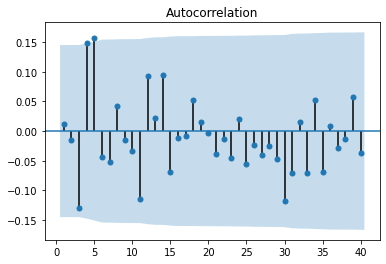

In [133]:
sgt.plot_acf(residuales, zero = False, lags=40)
print('No hay correlación entre los residuales')
plt.show()

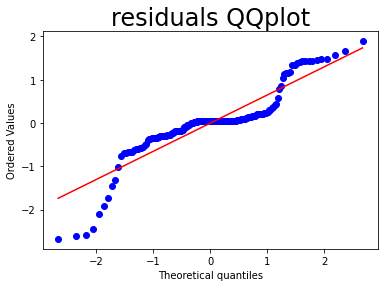

In [135]:
scipy.stats.probplot(residuales, plot = plt)
plt.title('residuals QQplot', size = 24)
print('No se comportan de manera normal')
plt.show()

No se puede concluir que este modelo sea bueno para realizar predicciones debido a que no cumple el supuesto de normalidad en los residuales, de hecho se puede notar en la gráfica de 'training data VS model fitting' que por esta falla en los supuestos no se logran modelar correctamente las medidas.

#Análisis de sequía por cuerpo de agua obtenido

## Presa 'La Purísima'  Gto

In [139]:
#Lectura del archivo en donde se tienen las 'medidas' de la presa y fechas de cada imágen
purisima = pd.read_csv(f'/content/drive/MyDrive/HackathonAiLab2021/Code/images3/cantidad_de_agua_PresaLaPurisimaGto.csv')
purisima = purisima.iloc[:,[2,3,4,6]]
purisima.columns = ['anio', 'mes','dia','area']
purisima['Date'] = purisima.anio.astype(str)+purisima.mes.astype(str).str.zfill(2)+purisima.dia.astype(str).str.zfill(2)
purisima['Date'] = pd.to_datetime(purisima['Date'],format='%Y/%m/%d')
purisima = purisima.sort_values('Date')
purisima = purisima.groupby('Date').agg({'area':np.mean}).reset_index()
#purisima

In [151]:
#Concatenación de una tasa de sequía
purisima['tasa_sequia'] = 1-purisima['area']/np.max(purisima['area'])
purisima.head(5)

,Date,area,tasa_sequia
0,2018-12-21,564114.0,0.662320
1,2019-01-05,550880.0,0.670242
2,2019-01-10,546981.0,0.672576
3,2019-01-20,540835.0,0.676255
4,2019-01-25,539725.0,0.676919


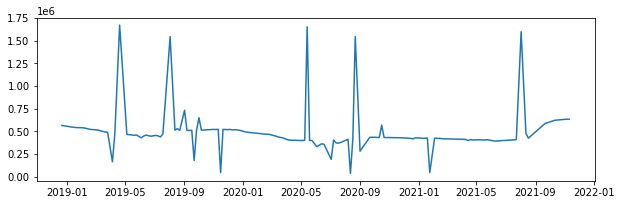

In [141]:
fig = plt.figure(figsize = (10,3))
plt.plot(purisima['Date'],purisima['area'])
plt.show()

Se puede visualizar que la temporada de sequía en la Presa 'La Purísima' se encuentra más presente de julio a noviembre y la de menor sequía de mayo a agosto. Esto se verifica con el siguiente análisis e imágenes

In [152]:
purisima[purisima.area<0.25e6]

,Date,area,tasa_sequia
15,2019-04-05,164038.0,0.901806
38,2019-09-22,177930.5,0.893490
45,2019-11-16,44628.0,0.973286
76,2020-07-03,190110.5,0.886199
82,2020-08-12,35642.5,0.978664
104,2021-01-24,43802.0,0.973780


IMAGEN DE LA FECHA 2020-07-03


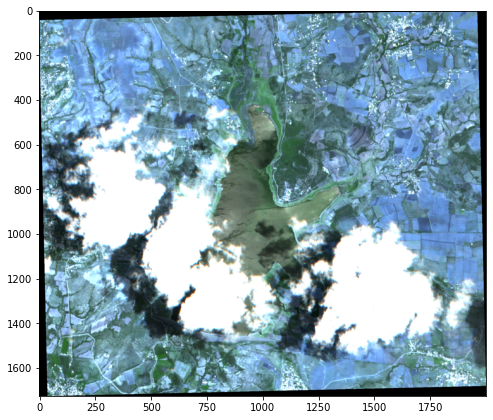

In [146]:
img = cv2.imread('/content/drive/MyDrive/HackathonAiLab2021/Code/images3/PresaLaPurisimaGto_Color/sentinel2_B11_2020_7_3_0.png')
fig = plt.figure(figsize = (8,10))
plt.imshow(img)
print('IMAGEN DE LA FECHA 2020-07-03')
plt.show()

In [153]:
purisima[purisima.area>1.5e6]

,Date,area,tasa_sequia
17,2019-04-20,1670557.0,0.000000
31,2019-08-03,1544715.0,0.075329
70,2020-05-14,1652773.0,0.010646
84,2020-08-22,1545358.0,0.074944
126,2021-08-02,1598106.0,0.043369


IMAGEN DE LA FECHA 2020-07-03


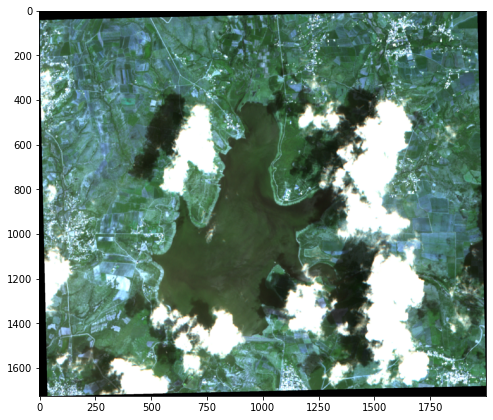

In [147]:
img = cv2.imread('/content/drive/MyDrive/HackathonAiLab2021/Code/images3/PresaLaPurisimaGto_Color/sentinel2_B11_2020_8_22_6.png')
fig = plt.figure(figsize = (8,10))
plt.imshow(img)
print('IMAGEN DE LA FECHA 2020-08-22')
plt.show()

## Lago Yuriria Gto

In [158]:
#Lectura del archivo en donde se tienen las 'medidas' de la presa y fechas de cada imágen
yuriria = pd.read_csv(f'/content/drive/MyDrive/HackathonAiLab2021/Code/images3/cantidad_de_agua_LagoYuririaGto.csv')
yuriria = yuriria.iloc[:,[3,4,5,7]]
yuriria.columns = ['anio', 'mes','dia','area']
yuriria['Date'] = yuriria.anio.astype(str)+yuriria.mes.astype(str).str.zfill(2)+yuriria.dia.astype(str).str.zfill(2)
yuriria['Date'] = pd.to_datetime(yuriria['Date'],format='%Y/%m/%d')
yuriria = yuriria.sort_values('Date')
yuriria = yuriria.groupby('Date').agg({'area':np.mean}).reset_index()
#yuriria

In [159]:
#Concatenación de una tasa de sequía
yuriria['tasa_sequia'] = 1-yuriria['area']/np.max(yuriria['area'])
yuriria.head(5)

,Date,area,tasa_sequia
0,2018-12-21,755000.5,0.743175
1,2018-12-26,593330.5,0.798170
2,2019-01-05,599869.0,0.795945
3,2019-01-10,619130.5,0.789393
4,2019-01-20,613359.0,0.791357


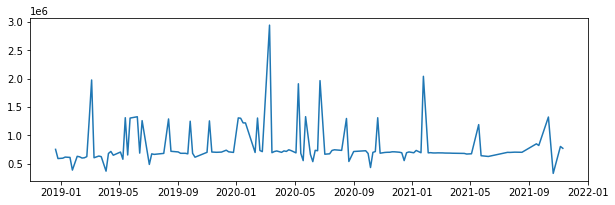

In [160]:
fig = plt.figure(figsize = (10,3))
plt.plot(yuriria['Date'],yuriria['area'])
plt.show()

Se puede visualizar que la temporada de sequía en el Lago Yuriria se encuentra más presente durante el mes de julio y en octubre; mientras que la temporada de menor sequía se da de marzo a mayo o principios de junio. Esto se verifica con el siguiente análisis.

In [162]:
yuriria[yuriria.area<0.5e6]

,Date,area,tasa_sequia
5,2019-01-25,390477.0,0.867173
16,2019-04-05,371651.0,0.873577
28,2019-07-04,490112.0,0.833281
87,2020-10-06,435454.0,0.851874
133,2021-10-21,332439.0,0.886916


In [166]:
yuriria[yuriria.area>1.5e6]

,Date,area,tasa_sequia
12,2019-03-06,1975136.5,0.328127
58,2020-03-10,2939748.0,0.000000
68,2020-05-09,1908587.5,0.350765
76,2020-06-23,1963725.0,0.332009
105,2021-01-24,2039632.0,0.306188


## Lago de Chapala Jal

In [169]:
#Lectura del archivo en donde se tienen las 'medidas' de la presa y fechas de cada imágen
chapala = pd.read_csv(f'/content/drive/MyDrive/HackathonAiLab2021/Code/images3/cantidad_de_agua_LagoDeChapala.csv')
chapala = chapala.iloc[:,[2,3,4,6]]
chapala.columns = ['anio', 'mes','dia','area']
chapala['Date'] = chapala.anio.astype(str)+chapala.mes.astype(str).str.zfill(2)+chapala.dia.astype(str).str.zfill(2)
chapala['Date'] = pd.to_datetime(chapala['Date'],format='%Y/%m/%d')
chapala = chapala.sort_values('Date')
chapala = chapala.groupby('Date').agg({'area':np.mean}).reset_index()

In [171]:
#Concatenación de una tasa de sequía
chapala['tasa_sequia'] = 1-chapala['area']/np.max(chapala['area'])
chapala.head(5)

,Date,area,tasa_sequia
0,2018-12-24,368244.5,0.877909
1,2019-01-03,433542.0,0.856260
2,2019-01-08,434751.5,0.855859
3,2019-01-13,1630839.5,0.459297
4,2019-01-18,321418.5,0.893434


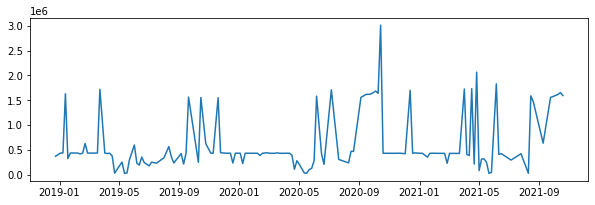

In [172]:
fig = plt.figure(figsize = (10,3))
plt.plot(chapala['Date'],chapala['area'])
plt.show()

Se puede visualizar que la temporada de sequía en el Lago de Chapala se da de enero a julio; mientras que la temporada de menor sequía se da de septiembre a octubre. Esto se verifica con el siguiente análisis.

In [185]:
chapala[chapala.area<0.25e6]

,Date,area,tasa_sequia
21,2019-04-23,27170.5,0.990992
22,2019-05-03,180444.5,0.940174
23,2019-05-08,249256.0,0.917359
24,2019-05-13,22880.5,0.992414
25,2019-05-18,31208.5,0.989653
28,2019-06-07,230100.0,0.923711
29,2019-06-12,190522.0,0.936833
31,2019-06-22,242148.5,0.919716
32,2019-07-02,174896.0,0.942013
33,2019-07-07,249000.0,0.917444


In [186]:
chapala[chapala.area>1.5e6]

,Date,area,tasa_sequia
3,2019-01-13,1.630840e+06,0.459297
16,2019-03-24,1.720874e+06,0.429446
42,2019-09-20,1.563787e+06,0.481528
44,2019-10-15,1.555838e+06,0.484163
48,2019-11-19,1.551445e+06,0.485620
79,2020-06-06,1.582895e+06,0.475192
82,2020-07-06,1.709477e+06,0.433224
87,2020-09-04,1.556084e+06,0.484081
88,2020-09-14,1.615805e+06,0.464281
89,2020-09-24,1.623118e+06,0.461857


## Lago de Janitzio Mich

In [187]:
#Lectura del archivo en donde se tienen las 'medidas' de la presa y fechas de cada imágen
janitzio = pd.read_csv(f'/content/drive/MyDrive/HackathonAiLab2021/Code/images3/cantidad_de_agua_Janitzio.csv')
janitzio = janitzio.iloc[:,[2,3,4,6]]
janitzio.columns = ['anio', 'mes','dia','area']
janitzio['Date'] = janitzio.anio.astype(str)+janitzio.mes.astype(str).str.zfill(2)+janitzio.dia.astype(str).str.zfill(2)
janitzio['Date'] = pd.to_datetime(chapala['Date'],format='%Y/%m/%d')
janitzio = janitzio.sort_values('Date')
janitzio = janitzio.groupby('Date').agg({'area':np.mean}).reset_index()

In [188]:
#Concatenación de una tasa de sequía
janitzio['tasa_sequia'] = 1-janitzio['area']/np.max(janitzio['area'])
janitzio.head(5)

,Date,area,tasa_sequia
0,2018-12-24,394247.0,0.880328
1,2019-01-03,351361.0,0.893346
2,2019-01-08,342388.0,0.896070
3,2019-01-13,457027.0,0.861272
4,2019-01-18,450193.0,0.863346


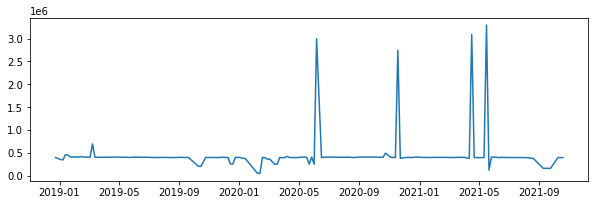

In [189]:
fig = plt.figure(figsize = (10,3))
plt.plot(janitzio['Date'],janitzio['area'])
plt.show()

## Laguna de Catemaco Ver

In [190]:
#Lectura del archivo en donde se tienen las 'medidas' de la presa y fechas de cada imágen
catemaco = pd.read_csv(f'/content/drive/MyDrive/HackathonAiLab2021/Code/images3/cantidad_de_agua_Catemaco.csv')
catemaco = catemaco.iloc[:,[2,3,4,6]]
catemaco.columns = ['anio', 'mes','dia','area']
catemaco['Date'] = catemaco.anio.astype(str)+catemaco.mes.astype(str).str.zfill(2)+catemaco.dia.astype(str).str.zfill(2)
catemaco['Date'] = pd.to_datetime(catemaco['Date'],format='%Y/%m/%d')
catemaco = catemaco.sort_values('Date')
catemaco = catemaco.groupby('Date').agg({'area':np.mean}).reset_index()

In [191]:
#Concatenación de una tasa de sequía
catemaco['tasa_sequia'] = 1-catemaco['area']/np.max(catemaco['area'])

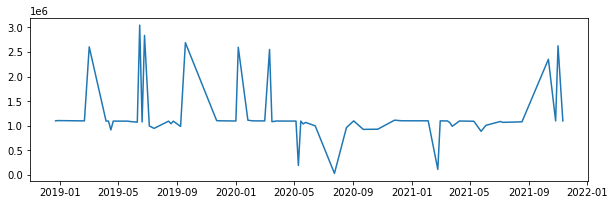

In [192]:
fig = plt.figure(figsize = (10,3))
plt.plot(catemaco['Date'],catemaco['area'])
plt.show()

En este caso particular, se puede ver que durante el periodo de mayo de 2020 a octubre a 2021 se presentó 'una sequía' comparada con las demás fechas estudiadas